## OVO Project : A Simplified Convex Optimization Model for Image Restoration with Multiplicative Noise

**Abdennacer Badaoui**

### Import Libraries

In [1]:
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
import cv2
import matplotlib.pyplot as plt 

### Dataset preparation

In [2]:
def mat_to_png(input_folder, output_folder):
    """
    Convert all .mat images in a folder to .png format and save them to an output folder.

    Parameters:
        input_folder (str): Path to the folder containing .mat files.
        output_folder (str): Path to the folder where .png files will be saved.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all .mat files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mat"):
            mat_path = os.path.join(input_folder, filename)
            # Load the .mat file
            mat_data = loadmat(mat_path)

            # Assuming the image data is stored in a key named 'image' or similar
            # Find the key containing the image data
            for key in mat_data:
                if isinstance(mat_data[key], np.ndarray):
                    image_data = mat_data[key]
                    break
            else:
                print(f"No valid image data found in {filename}")
                continue

            # Normalize the image data if needed (e.g., scale to 0-255)
            image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
            image_data = (image_data * 255).astype(np.uint8)

            # Convert to PIL Image
            image = Image.fromarray(image_data)

            # Save as .png
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")
            image.save(output_path)
            print(f"Saved {output_path}")

# Example usage
input_folder = "data_mat"  
output_folder = "data"  
mat_to_png(input_folder, output_folder)


Saved data\boat_10.png
Saved data\boat_10_gaussian_772.png
Saved data\boat_20.png
Saved data\boat_20_gaussian_772.png
Saved data\boat_6.png
Saved data\boat_6_gaussian_772.png
Saved data\cameraman_10.png
Saved data\cameraman_10_gaussian_772.png
Saved data\cameraman_20.png
Saved data\cameraman_20_gaussian_772.png
Saved data\cameraman_6.png
Saved data\cameraman_6_gaussian_772.png
Saved data\circle_10.png
Saved data\circle_20.png
Saved data\circle_6.png
Saved data\House_10.png
Saved data\House_10_gaussian_772.png
Saved data\House_20.png
Saved data\House_20_gaussian_772.png
Saved data\House_6.png
Saved data\House_6_gaussian_772.png
Saved data\lenna-20_gaussian_772.png
Saved data\lenna_10.png
Saved data\lenna_10_gaussian_772.png
Saved data\lenna_20.png
Saved data\lenna_6.png
Saved data\lenna_6_gaussian_772.png
Saved data\parrot_10.png
Saved data\parrot_10_gaussian_772.png
Saved data\parrot_20.png
Saved data\parrot_20_gaussian_772.png
Saved data\parrot_6.png
Saved data\parrot_6_gaussian_772.p

### Metric (PSNR)

In [3]:
def PSNR(original, reconstructed):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.
    
    Parameters:
        original (numpy.ndarray): The original image (grayscale).
        reconstructed (numpy.ndarray): The reconstructed image (grayscale).
        
    Returns:
        float: The PSNR value.
    """
    max_intensity = np.max(original)
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')  # Infinite PSNR for identical images
    return 10 * np.log10(max_intensity ** 2 / mse)

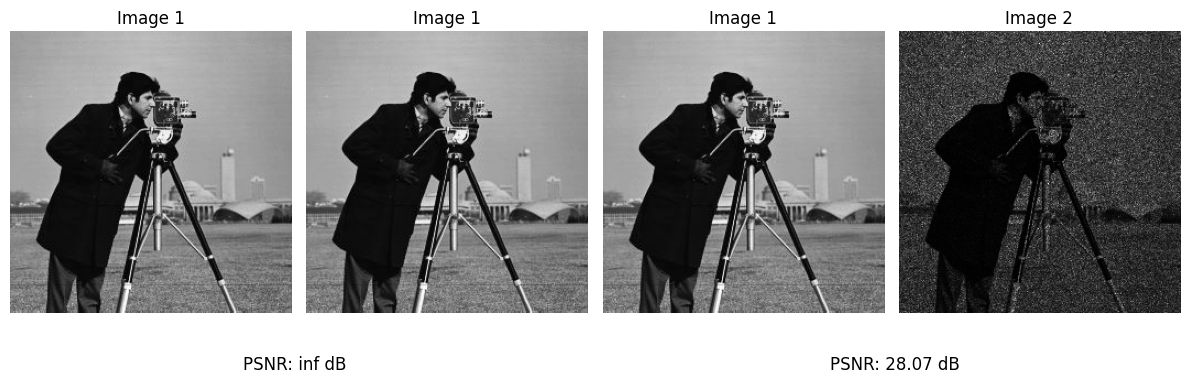

In [4]:
# Load images
image1 = cv2.imread("data/cameraman.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("data/cameraman_6.png", cv2.IMREAD_GRAYSCALE)

# Calculate PSNR values
psnr1 = PSNR(image1, image1)  
psnr2 = PSNR(image1, image2)  

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(image1, cmap='gray')
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(image1, cmap='gray')
axes[1].set_title("Image 1")
axes[1].axis('off')

fig.text(0.25, 0.02, f"PSNR: {psnr1:.2f} dB", ha='center', va='center', fontsize=12)

axes[2].imshow(image1, cmap='gray')
axes[2].set_title("Image 1")
axes[2].axis('off')

axes[3].imshow(image2, cmap='gray')
axes[3].set_title("Image 2")
axes[3].axis('off')

fig.text(0.75, 0.02, f"PSNR: {psnr2:.2f} dB", ha='center', va='center', fontsize=12)
plt.subplots_adjust(wspace=0.1)  

# Display the plot
plt.tight_layout()
plt.show()

### Model 

Starting restoration...


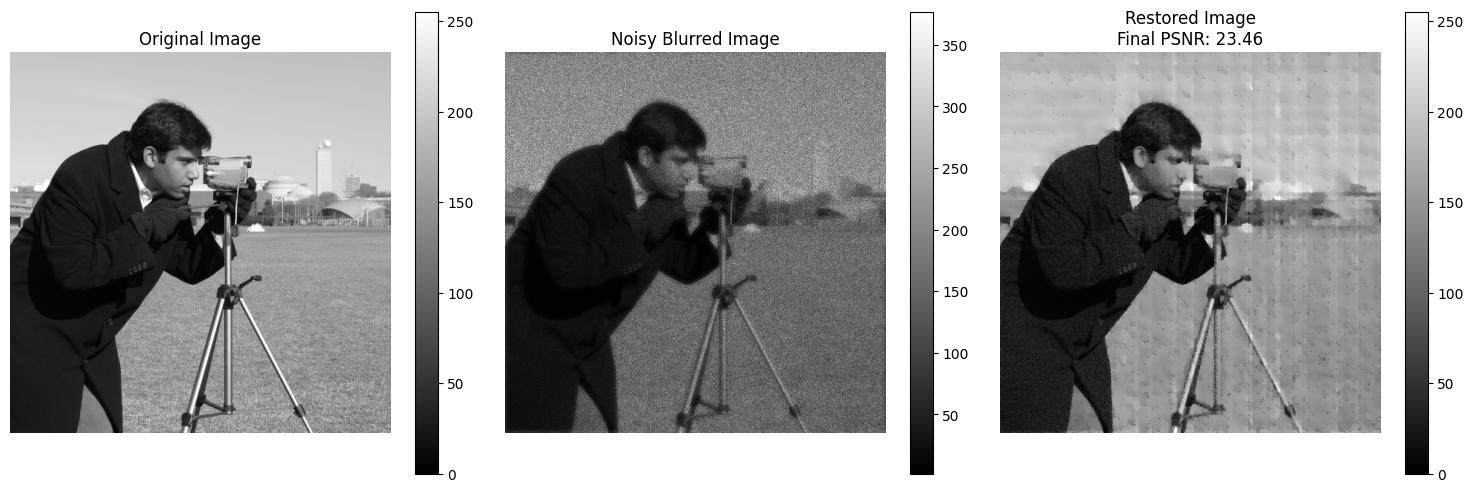


Restoration Summary:
Algorithm did not converge
Total iterations: 100
Final PSNR: 23.46


In [17]:
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
from scipy import fftpack
import matplotlib.pyplot as plt
from skimage import data
import scipy.stats as stats
from typing import Dict, Any, Tuple

def forward_d(u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Forward finite difference operator"""
    m, n = u.shape
    dx = np.zeros_like(u)
    dx[:, :-1] = np.diff(u, axis=1)
    dx[:, -1] = u[:, 0] - u[:, -1]
    
    dy = np.zeros_like(u)
    dy[:-1, :] = np.diff(u, axis=0)
    dy[-1, :] = u[0, :] - u[-1, :]
    
    return dx, dy

def dive(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Transpose of the forward finite difference operator"""
    divergence = np.zeros_like(x)
    divergence[:, :] = np.roll(x[:, -1:], 1, axis=1) - x[:, :]
    divergence[:, 1:] -= np.diff(x, axis=1)
    divergence[:, :] += np.roll(y[-1:, :], 1, axis=0) - y[:, :]
    divergence[1:, :] -= np.diff(y, axis=0)
    return divergence

def calculate_psnr(x: np.ndarray, y: np.ndarray) -> float:
    """Calculate PSNR between two images with proper handling of ranges"""
    # Ensure the images are in the same range
    if x.max() <= 1.0 and y.max() <= 1.0:
        x = x * 255.0
        y = y * 255.0
    
    mse = np.mean((x - y) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_ssim(img1: np.ndarray, img2: np.ndarray) -> float:
    """Calculate SSIM between two images"""
    K = [0.01, 0.03]
    L = 255
    
    window = np.zeros((11,11))
    window[5,5] = 1
    window = ndimage.gaussian_filter(window, sigma=1.5)
    window = window/window.sum()
    
    c1 = (K[0]*L)**2
    c2 = (K[1]*L)**2
    
    mu1 = ndimage.convolve(img1, window, mode='reflect')
    mu2 = ndimage.convolve(img2, window, mode='reflect')
    
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    
    sigma1_sq = ndimage.convolve(img1*img1, window, mode='reflect') - mu1_sq
    sigma2_sq = ndimage.convolve(img2*img2, window, mode='reflect') - mu2_sq
    sigma12 = ndimage.convolve(img1*img2, window, mode='reflect') - mu1_mu2
    
    ssim_map = ((2*mu1_mu2 + c1)*(2*sigma12 + c2))/((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
    return float(np.mean(ssim_map))


def cmc(psf: np.ndarray, noisy_image: np.ndarray, original_image: np.ndarray, 
        noise: np.ndarray, mean_w: float, opts: Dict[str, Any]) -> Dict[str, Any]:
    """Main CMC algorithm implementation with fixed PSNR"""
    # Extract parameters with new default values
    beta1 = opts.get('beta1', 1.0)
    beta2 = opts.get('beta2', 0.1)
    alpha1 = opts.get('alpha1', 0.01)
    max_iterations = opts.get('max_iterations', 1000)
    tolerance = opts.get('tolerance', 5e-5)
    
    # Normalize input images to [0,1] range for processing
    scale_factor = 255.0
    noisy_image = noisy_image / scale_factor
    original_image_normalized = original_image / scale_factor
    
    m, n = noisy_image.shape
    
    # Initialize variables
    lambda1 = np.zeros((2*m, n))
    lambda2 = np.zeros((m, n))
    restored_image = noisy_image.copy()
    weights = np.zeros((m, n))
    
    grad_x, grad_y = forward_d(noisy_image)
    
    metrics = {
        'ssim_values': [],
        'psnr_values': [],
        'relative_change': [],
        'restoration_error': [],
        'iteration_count': 0,
        'converged': False
    }
    
    relative_change = 1
    current_iteration = 0
    
    while relative_change > tolerance and current_iteration < max_iterations:
        previous_image = restored_image.copy()
        
        # Step 1: Update auxiliary variables
        z1 = grad_x + lambda1[:m,:]/beta2
        z2 = grad_y + lambda1[m:,:]/beta2
        magnitude = np.sqrt(z1**2 + z2**2)
        magnitude[magnitude == 0] = 1
        v = np.maximum(magnitude - alpha1/beta2, 0)/magnitude
        p = np.vstack((z1*v, z2*v))
        
        # Step 2: Update weights
        blurred = ndimage.convolve(restored_image, psf, mode='wrap')
        right_term = mean_w*np.ones((m,n)) + noisy_image*(beta1*blurred + lambda2)
        weights = right_term/(np.ones((m,n)) + beta1*(noisy_image**2))
        
        # Step 3: Update restored image in Fourier domain
        b1_1 = beta2*dive(p[:m,:], p[m:,:])
        b1_2 = -dive(lambda1[:m,:], lambda1[m:,:])
        b1_3 = beta1*ndimage.convolve(noisy_image*weights, psf[::-1,::-1], mode='wrap')
        b1_4 = -ndimage.convolve(lambda2, psf[::-1,::-1], mode='wrap')
        
        b1 = fftpack.fft2(b1_1 + b1_2 + b1_3 + b1_4)
        
        # Modified FFT operations
        psf_freq = fftpack.fft2(psf, shape=(m,n))
        psf_power = np.abs(psf_freq)**2
        grad_power = (np.abs(fftpack.fft2(np.array([[1, -1]]), (m,n)))**2 + 
                     np.abs(fftpack.fft2(np.array([[1], [-1]]), (m,n)))**2)
        
        # Ensure numerical stability
        denominator = beta1*psf_power + beta2*grad_power
        denominator[denominator < 1e-10] = 1e-10
        
        restored_image = np.real(fftpack.ifft2(b1/denominator))
        restored_image = np.clip(restored_image, 0, 1)  # Ensure values stay in [0,1]
        
        grad_x, grad_y = forward_d(restored_image)
        
        # Calculate metrics using normalized images
        current_psnr = calculate_psnr(restored_image * scale_factor, original_image)
        current_ssim = calculate_ssim(restored_image * scale_factor, original_image)
        relative_change = np.linalg.norm(restored_image - previous_image)/np.linalg.norm(restored_image)
        
        # Store metrics
        metrics['psnr_values'].append(current_psnr)
        metrics['ssim_values'].append(current_ssim)
        metrics['relative_change'].append(relative_change)
        metrics['restoration_error'].append(
            np.linalg.norm(restored_image - original_image_normalized)/np.linalg.norm(original_image_normalized)
        )
        
        
        # Update Lagrange multipliers
        blurred = ndimage.convolve(restored_image, psf, mode='wrap')
        lambda1[:m,:] = lambda1[:m,:] + beta2*(grad_x - p[:m,:])
        lambda1[m:,:] = lambda1[m:,:] + beta2*(grad_y - p[m:,:])
        lambda2 = lambda2 + beta1*(blurred - noisy_image*weights)
        
        current_iteration += 1
    
    # Scale back the restored image to original range
    metrics['solution'] = np.clip(restored_image * scale_factor, 0, 255)
    metrics['iteration_count'] = current_iteration
    metrics['converged'] = relative_change <= tolerance
    
    return metrics

def test_cmc(img, max_iterations: int = 1000):
    """Test the CMC implementation with improved parameters"""
    # Load and prepare test image
    img = img.astype(float)
    m, n = img.shape
    
    # Generate noise
    L = 40  # Look parameter
    np.random.seed(42)
    noise_matrix = stats.gamma.rvs(L, scale=1/L, size=(m, n))
    mean_inverse_noise = np.sum(1. / noise_matrix) / (m * n)
    
    # Create and apply blur kernel
    kernel_size = 11  # Increase the kernel size for stronger blurring
    sigma_value = 4  # Increase sigma for a more intense blur

    psf = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    psf[kernel_size // 2, kernel_size // 2] = 1
    psf = psf / psf.sum()  # Normalize to make sure it's a valid filter
        
    # Create noisy blurred image
    noisy_blurred = ndimage.convolve(img, psf, mode='wrap') * noise_matrix
    
    # New improved parameters
    parameters = {
        'beta1': 1.0,
        'beta2': 0.1,
        'alpha1': 0.1,
        'max_iterations': max_iterations,
        'tolerance': 5e-5
    }
    
    print("Starting restoration...")
    
    # Run CMC algorithm
    results = cmc(psf, noisy_blurred, img, noise_matrix, mean_inverse_noise, parameters)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')  # Hide axes
    plt.colorbar()
    
    # Noisy Blurred Image
    plt.subplot(132)
    plt.imshow(noisy_blurred, cmap='gray')
    plt.title('Noisy Blurred Image')
    plt.axis('off')  # Hide axes
    plt.colorbar()
    
    # Restored Image
    plt.subplot(133)
    plt.imshow(results['solution'], cmap='gray')
    plt.title(f"Restored Image\nFinal PSNR: {results['psnr_values'][-1]:.2f}")
    plt.axis('off')  # Hide axes
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nRestoration Summary:")
    print(f"Algorithm {'converged' if results['converged'] else 'did not converge'}")
    print(f"Total iterations: {results['iteration_count']}")
    print(f"Final PSNR: {results['psnr_values'][-1]:.2f}")

if __name__ == "__main__":
    img = data.camera()
    test_cmc(img, max_iterations=100)

Starting restoration...


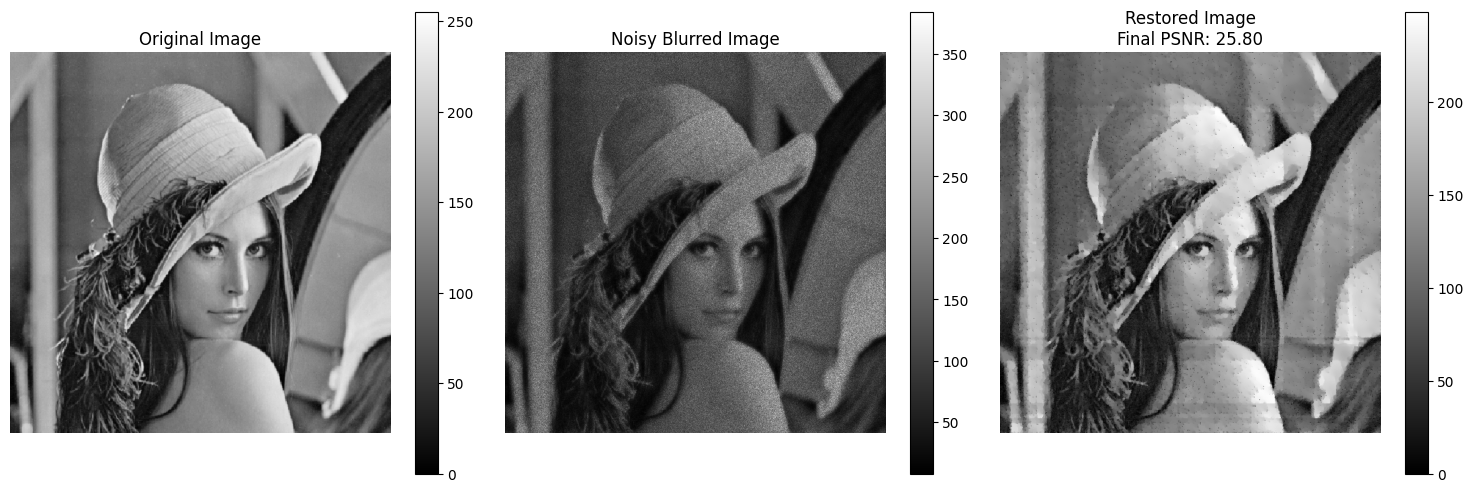


Restoration Summary:
Algorithm did not converge
Total iterations: 100
Final PSNR: 25.80


In [18]:
img = Image.open("data/lena.png")
img = np.array(img.convert('L'))
test_cmc(img, max_iterations=100)